In [1]:
import os
import datetime
from tqdm import tqdm

import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
from torchvision.transforms import functional as TF
from skimage.feature import blob_log

from models.Unet_ResNetEncoder.Unet_ResNetEncoder import UNetWithResNetEncoder
from models.Unet.trainer import train
from datasets.datasets import Dataset_TEMImageNet, preprocessing_label, preprocessing_image
from utils.utils import *

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)
# MODEL_ATOMS = './results/Unet_20240408-214232_lr=0.01_wd=0.0005_circularMask/weight.pth'
# MODEL_VACANCIES = './results/Unet_20240401-105229_lr=0.01_wd=0.0005_vacancies/weight.pth'
# MODEL_DOPANTS = './results/Unet_20240401-112737_lr=0.01_wd=0.0005_dopants/weight.pth'

# from models.FasterRcnn import mAP
from mpl_toolkits.axes_grid1 import ImageGrid

cuda


In [2]:
def resize_tensor(image, scale):  # (H, W)
    new_size = (int(image.shape[1] * scale), int(image.shape[2] * scale))
    new_image = TF.resize(image, new_size, interpolation=TF.InterpolationMode.BICUBIC, antialias=True)
    return new_image

def random_clip_tensor(image, crop_size=128):  # (H, W)
    H, W = image.shape
    top = torch.randint(H - crop_size + 1, (1,)).item()
    left = torch.randint(W - crop_size + 1, (1,)).item()
    image_clipped = image[top:top + crop_size, left:left + crop_size]
    return image_clipped

def preprocessing_test(image, scale=1, crop_size=128):  # (H, W)
    test_input = data_init_tensor(random_clip_tensor(resize_tensor(torch.as_tensor(image, dtype=torch.float32).unsqueeze(0), scale)[0], crop_size))
    return test_input.unsqueeze(0)  # (1, H, W)

def data_init(image):
    return (image - np.min(image)) / (np.max(image) - np.min(image))

def data_init_tensor(image):
    return (image - torch.min(image)) / (torch.max(image) - torch.min(image))

def renormalize(image):
    return np.uint8(image * 255)

def Otsu(origin_image):
    image = renormalize(data_init(origin_image))
    _, thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, _, _, centroids = cv2.connectedComponentsWithStats(np.uint8(thresh), connectivity=4, ltype=cv2.CV_32S)
    centroids = np.array(centroids[1:])  # remove background
    return centroids

def threshold_coord(origin_image, threshold):
    image = renormalize(data_init(origin_image))
    _, thresh = cv2.threshold(image, threshold*255, 255, cv2.THRESH_BINARY)
    retval, markers = cv2.connectedComponents(np.uint8(thresh))

    centroids = []
    for i in range(1, retval):
        region_mask = (markers == i).astype(np.uint8)
        moments = cv2.moments(region_mask)
        if moments["m00"] != 0:
            centroid_x = int(moments["m10"] / moments["m00"])
            centroid_y = int(moments["m01"] / moments["m00"])
        centroids.append((centroid_x, centroid_y))
    centroids = np.array(centroids)
    return centroids

In [3]:
dataset = Dataset_TEMImageNet('gaussianMask', 2)

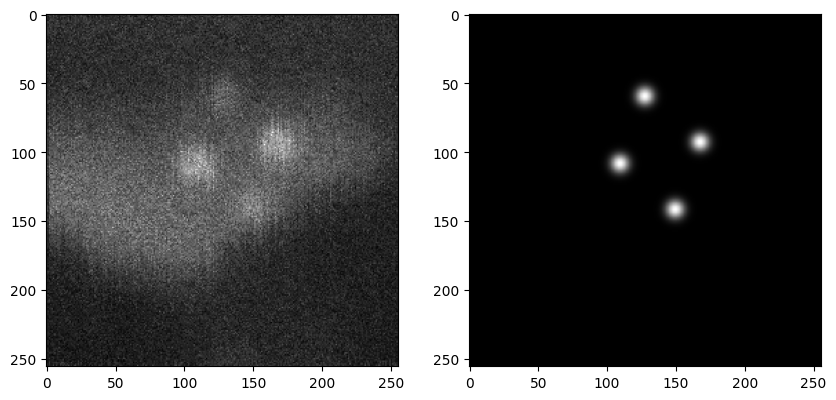

In [4]:
image, label = dataset[50]
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image[0], cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(label[1], cmap='gray')
plt.show()

In [5]:
# TEMImageNet
dataset = Dataset_TEMImageNet('gaussianMask', num_classes=2)
# # 计算划分的样本数量
# ratio = 0.9
# train_size = int(ratio * len(dataset))
# valtest_size = len(dataset) - train_size
# val_size = int(ratio * valtest_size)
# test_size = valtest_size - val_size

# # 使用 random_split 函数划分数据集
# train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(14128))
# train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True, num_workers=16, pin_memory=True)
# val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
# test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
train_dataloader = DataLoader(dataset, batch_size=40, shuffle=True, num_workers=16, pin_memory=False)

In [8]:
# 定义参数
epochs = 200
weight_decay = 0.0005
learning_rate_list =[2e-5, 4e-5, 6e-5, 8e-5]
loss_type = ['CrossEntropyLoss', 'ModifiedMSE'][0]

In [9]:
# 模型训练
for learning_rate in learning_rate_list:
    model = UNetWithResNetEncoder(num_classes=2)
    info = 'gaussianMask'
    current_time = datetime.datetime.now()
    current_time = datetime.datetime.strftime(current_time, r'%Y%m%d-%H%M%S')
    save_path = os.path.join('results', f'UnetWithResNet_{current_time}_lr={learning_rate}_wd={weight_decay}_{info}')
    train(model, device, save_path, train_dataloader, learning_rate, weight_decay, epochs, loss_type)

训练开始, 当前训练参数为: lr=2e-05, wd=0.0005


Epoch [5/200]: 100%|██████████| 360/360 [01:15<00:00,  4.79it/s, loss=0.670084, lr=0.000006]


Saved model and weights to disk.


Epoch [10/200]: 100%|██████████| 360/360 [01:34<00:00,  3.82it/s, loss=0.590960, lr=0.000011]


Saved model and weights to disk.


Epoch [15/200]: 100%|██████████| 360/360 [01:14<00:00,  4.83it/s, loss=0.503831, lr=0.000015]


Saved model and weights to disk.


Epoch [20/200]: 100%|██████████| 360/360 [01:15<00:00,  4.79it/s, loss=0.388396, lr=0.000020]


Saved model and weights to disk.


Epoch [25/200]: 100%|██████████| 360/360 [01:14<00:00,  4.84it/s, loss=0.317094, lr=0.000020]


Saved model and weights to disk.


Epoch [30/200]: 100%|██████████| 360/360 [01:14<00:00,  4.86it/s, loss=0.314143, lr=0.000020]


Saved model and weights to disk.


Epoch [35/200]: 100%|██████████| 360/360 [01:14<00:00,  4.86it/s, loss=0.250064, lr=0.000020]


Saved model and weights to disk.


Epoch [40/200]: 100%|██████████| 360/360 [01:17<00:00,  4.67it/s, loss=0.228512, lr=0.000019]


Saved model and weights to disk.


Epoch [45/200]: 100%|██████████| 360/360 [01:16<00:00,  4.70it/s, loss=0.227804, lr=0.000019]


Saved model and weights to disk.


Epoch [50/200]: 100%|██████████| 360/360 [01:16<00:00,  4.72it/s, loss=0.185508, lr=0.000019]


Saved model and weights to disk.


Epoch [55/200]: 100%|██████████| 360/360 [01:14<00:00,  4.80it/s, loss=0.213516, lr=0.000018]


Saved model and weights to disk.


Epoch [60/200]: 100%|██████████| 360/360 [01:18<00:00,  4.56it/s, loss=0.178143, lr=0.000018]


Saved model and weights to disk.


Epoch [65/200]: 100%|██████████| 360/360 [01:28<00:00,  4.05it/s, loss=0.206139, lr=0.000017]


Saved model and weights to disk.


Epoch [70/200]: 100%|██████████| 360/360 [02:16<00:00,  2.63it/s, loss=0.182281, lr=0.000017]


Saved model and weights to disk.


Epoch [75/200]: 100%|██████████| 360/360 [02:00<00:00,  2.98it/s, loss=0.123410, lr=0.000016]


Saved model and weights to disk.


Epoch [80/200]: 100%|██████████| 360/360 [02:03<00:00,  2.92it/s, loss=0.143880, lr=0.000015]


Saved model and weights to disk.


Epoch [85/200]: 100%|██████████| 360/360 [01:58<00:00,  3.04it/s, loss=0.154246, lr=0.000015]


Saved model and weights to disk.


Epoch [90/200]: 100%|██████████| 360/360 [01:15<00:00,  4.75it/s, loss=0.221860, lr=0.000014]


Saved model and weights to disk.


Epoch [95/200]: 100%|██████████| 360/360 [01:15<00:00,  4.79it/s, loss=0.128842, lr=0.000013]


Saved model and weights to disk.


Epoch [100/200]: 100%|██████████| 360/360 [01:15<00:00,  4.78it/s, loss=0.148195, lr=0.000012]


Saved model and weights to disk.


Epoch [105/200]: 100%|██████████| 360/360 [01:18<00:00,  4.60it/s, loss=0.166022, lr=0.000011]


Saved model and weights to disk.


Epoch [110/200]: 100%|██████████| 360/360 [01:21<00:00,  4.43it/s, loss=0.144875, lr=0.000011]


Saved model and weights to disk.


Epoch [115/200]: 100%|██████████| 360/360 [01:15<00:00,  4.76it/s, loss=0.196821, lr=0.000010]


Saved model and weights to disk.


Epoch [120/200]: 100%|██████████| 360/360 [01:15<00:00,  4.77it/s, loss=0.174780, lr=0.000009]


Saved model and weights to disk.


Epoch [125/200]: 100%|██████████| 360/360 [01:19<00:00,  4.53it/s, loss=0.142163, lr=0.000008]


Saved model and weights to disk.


Epoch [130/200]: 100%|██████████| 360/360 [01:38<00:00,  3.66it/s, loss=0.168443, lr=0.000007]


Saved model and weights to disk.


Epoch [135/200]: 100%|██████████| 360/360 [01:13<00:00,  4.92it/s, loss=0.145939, lr=0.000006]


Saved model and weights to disk.


Epoch [140/200]: 100%|██████████| 360/360 [01:15<00:00,  4.77it/s, loss=0.102636, lr=0.000006]


Saved model and weights to disk.


Epoch [145/200]: 100%|██████████| 360/360 [01:12<00:00,  4.95it/s, loss=0.116424, lr=0.000005]


Saved model and weights to disk.


Epoch [150/200]: 100%|██████████| 360/360 [01:13<00:00,  4.92it/s, loss=0.154057, lr=0.000004]


Saved model and weights to disk.


Epoch [155/200]: 100%|██████████| 360/360 [01:31<00:00,  3.91it/s, loss=0.142835, lr=0.000004]


Saved model and weights to disk.


Epoch [160/200]: 100%|██████████| 360/360 [01:48<00:00,  3.32it/s, loss=0.117469, lr=0.000003]


Saved model and weights to disk.


Epoch [165/200]: 100%|██████████| 360/360 [01:50<00:00,  3.26it/s, loss=0.125717, lr=0.000003]


Saved model and weights to disk.


Epoch [170/200]: 100%|██████████| 360/360 [01:23<00:00,  4.33it/s, loss=0.194785, lr=0.000002]


Saved model and weights to disk.


Epoch [175/200]: 100%|██████████| 360/360 [01:22<00:00,  4.39it/s, loss=0.187463, lr=0.000002]


Saved model and weights to disk.


Epoch [180/200]: 100%|██████████| 360/360 [01:19<00:00,  4.52it/s, loss=0.159136, lr=0.000002]


Saved model and weights to disk.


Epoch [185/200]: 100%|██████████| 360/360 [01:23<00:00,  4.33it/s, loss=0.157867, lr=0.000001]


Saved model and weights to disk.


Epoch [190/200]: 100%|██████████| 360/360 [01:31<00:00,  3.95it/s, loss=0.130956, lr=0.000001]


Saved model and weights to disk.


Epoch [195/200]: 100%|██████████| 360/360 [01:16<00:00,  4.70it/s, loss=0.135244, lr=0.000001]


Saved model and weights to disk.


Epoch [200/200]: 100%|██████████| 360/360 [01:21<00:00,  4.41it/s, loss=0.153981, lr=0.000001]


Saved model and weights to disk.
训练开始, 当前训练参数为: lr=4e-05, wd=0.0005


Epoch [5/200]: 100%|██████████| 360/360 [01:14<00:00,  4.85it/s, loss=0.607934, lr=0.000011]


Saved model and weights to disk.


Epoch [10/200]: 100%|██████████| 360/360 [01:14<00:00,  4.84it/s, loss=0.491620, lr=0.000021]


Saved model and weights to disk.


Epoch [15/200]: 100%|██████████| 360/360 [01:13<00:00,  4.90it/s, loss=0.363572, lr=0.000030]


Saved model and weights to disk.


Epoch [20/200]: 100%|██████████| 360/360 [01:14<00:00,  4.85it/s, loss=0.284971, lr=0.000040]


Saved model and weights to disk.


Epoch [25/200]: 100%|██████████| 360/360 [01:14<00:00,  4.86it/s, loss=0.243157, lr=0.000040]


Saved model and weights to disk.


Epoch [30/200]: 100%|██████████| 360/360 [01:15<00:00,  4.77it/s, loss=0.222915, lr=0.000040]


Saved model and weights to disk.


Epoch [35/200]: 100%|██████████| 360/360 [01:14<00:00,  4.82it/s, loss=0.208959, lr=0.000039]


Saved model and weights to disk.


Epoch [40/200]: 100%|██████████| 360/360 [01:13<00:00,  4.87it/s, loss=0.190297, lr=0.000039]


Saved model and weights to disk.


Epoch [45/200]: 100%|██████████| 360/360 [01:15<00:00,  4.77it/s, loss=0.191978, lr=0.000038]


Saved model and weights to disk.


Epoch [50/200]: 100%|██████████| 360/360 [01:14<00:00,  4.81it/s, loss=0.226756, lr=0.000037]


Saved model and weights to disk.


Epoch [55/200]: 100%|██████████| 360/360 [01:14<00:00,  4.85it/s, loss=0.144293, lr=0.000036]


Saved model and weights to disk.


Epoch [60/200]: 100%|██████████| 360/360 [01:14<00:00,  4.83it/s, loss=0.220118, lr=0.000035]


Saved model and weights to disk.


Epoch [65/200]: 100%|██████████| 360/360 [01:14<00:00,  4.83it/s, loss=0.138994, lr=0.000034]


Saved model and weights to disk.


Epoch [70/200]: 100%|██████████| 360/360 [01:13<00:00,  4.87it/s, loss=0.179461, lr=0.000033]


Saved model and weights to disk.


Epoch [75/200]: 100%|██████████| 360/360 [01:14<00:00,  4.82it/s, loss=0.157234, lr=0.000032]


Saved model and weights to disk.


Epoch [80/200]: 100%|██████████| 360/360 [01:13<00:00,  4.92it/s, loss=0.167672, lr=0.000030]


Saved model and weights to disk.


Epoch [85/200]: 100%|██████████| 360/360 [01:15<00:00,  4.79it/s, loss=0.176857, lr=0.000029]


Saved model and weights to disk.


Epoch [90/200]: 100%|██████████| 360/360 [01:34<00:00,  3.82it/s, loss=0.157480, lr=0.000027]


Saved model and weights to disk.


Epoch [95/200]: 100%|██████████| 360/360 [01:34<00:00,  3.80it/s, loss=0.136928, lr=0.000026]


Saved model and weights to disk.


Epoch [100/200]: 100%|██████████| 360/360 [01:34<00:00,  3.81it/s, loss=0.163980, lr=0.000024]


Saved model and weights to disk.


Epoch [105/200]: 100%|██████████| 360/360 [01:35<00:00,  3.78it/s, loss=0.103641, lr=0.000022]


Saved model and weights to disk.


Epoch [110/200]: 100%|██████████| 360/360 [01:35<00:00,  3.77it/s, loss=0.144970, lr=0.000021]


Saved model and weights to disk.


Epoch [115/200]: 100%|██████████| 360/360 [01:34<00:00,  3.80it/s, loss=0.095628, lr=0.000019]


Saved model and weights to disk.


Epoch [120/200]: 100%|██████████| 360/360 [01:35<00:00,  3.77it/s, loss=0.133363, lr=0.000017]


Saved model and weights to disk.


Epoch [125/200]: 100%|██████████| 360/360 [01:34<00:00,  3.80it/s, loss=0.135826, lr=0.000015]


Saved model and weights to disk.


Epoch [130/200]: 100%|██████████| 360/360 [01:35<00:00,  3.78it/s, loss=0.132055, lr=0.000014]


Saved model and weights to disk.


Epoch [135/200]: 100%|██████████| 360/360 [01:34<00:00,  3.80it/s, loss=0.094086, lr=0.000012]


Saved model and weights to disk.


Epoch [140/200]: 100%|██████████| 360/360 [01:35<00:00,  3.75it/s, loss=0.121946, lr=0.000011]


Saved model and weights to disk.


Epoch [145/200]: 100%|██████████| 360/360 [01:34<00:00,  3.82it/s, loss=0.133663, lr=0.000009]


Saved model and weights to disk.


Epoch [150/200]: 100%|██████████| 360/360 [01:34<00:00,  3.82it/s, loss=0.125890, lr=0.000008]


Saved model and weights to disk.


Epoch [155/200]: 100%|██████████| 360/360 [01:35<00:00,  3.78it/s, loss=0.115999, lr=0.000007]


Saved model and weights to disk.


Epoch [160/200]: 100%|██████████| 360/360 [01:36<00:00,  3.71it/s, loss=0.100997, lr=0.000006]


Saved model and weights to disk.


Epoch [165/200]: 100%|██████████| 360/360 [01:35<00:00,  3.76it/s, loss=0.082991, lr=0.000005]


Saved model and weights to disk.


Epoch [170/200]: 100%|██████████| 360/360 [01:35<00:00,  3.78it/s, loss=0.125512, lr=0.000004]


Saved model and weights to disk.


Epoch [175/200]: 100%|██████████| 360/360 [01:36<00:00,  3.75it/s, loss=0.125408, lr=0.000003]


Saved model and weights to disk.


Epoch [180/200]: 100%|██████████| 360/360 [01:34<00:00,  3.81it/s, loss=0.093334, lr=0.000002]


Saved model and weights to disk.


Epoch [185/200]: 100%|██████████| 360/360 [01:35<00:00,  3.78it/s, loss=0.161224, lr=0.000002]


Saved model and weights to disk.


Epoch [190/200]: 100%|██████████| 360/360 [01:35<00:00,  3.77it/s, loss=0.135605, lr=0.000001]


Saved model and weights to disk.


Epoch [195/200]: 100%|██████████| 360/360 [01:34<00:00,  3.79it/s, loss=0.118747, lr=0.000001]


Saved model and weights to disk.


Epoch [200/200]: 100%|██████████| 360/360 [01:34<00:00,  3.83it/s, loss=0.123354, lr=0.000001]


Saved model and weights to disk.
训练开始, 当前训练参数为: lr=6e-05, wd=0.0005


Epoch [5/200]: 100%|██████████| 360/360 [01:35<00:00,  3.76it/s, loss=0.595364, lr=0.000016]


Saved model and weights to disk.


Epoch [10/200]: 100%|██████████| 360/360 [01:38<00:00,  3.67it/s, loss=0.444461, lr=0.000031]


Saved model and weights to disk.


Epoch [15/200]: 100%|██████████| 360/360 [01:35<00:00,  3.78it/s, loss=0.303644, lr=0.000045]


Saved model and weights to disk.


Epoch [20/200]: 100%|██████████| 360/360 [01:35<00:00,  3.77it/s, loss=0.241375, lr=0.000060]


Saved model and weights to disk.


Epoch [25/200]: 100%|██████████| 360/360 [01:34<00:00,  3.79it/s, loss=0.185658, lr=0.000060]


Saved model and weights to disk.


Epoch [30/200]: 100%|██████████| 360/360 [01:34<00:00,  3.81it/s, loss=0.152993, lr=0.000060]


Saved model and weights to disk.


Epoch [35/200]: 100%|██████████| 360/360 [01:35<00:00,  3.77it/s, loss=0.134799, lr=0.000059]


Saved model and weights to disk.


Epoch [40/200]: 100%|██████████| 360/360 [01:34<00:00,  3.82it/s, loss=0.185297, lr=0.000058]


Saved model and weights to disk.


Epoch [45/200]: 100%|██████████| 360/360 [01:35<00:00,  3.76it/s, loss=0.170394, lr=0.000057]


Saved model and weights to disk.


Epoch [50/200]: 100%|██████████| 360/360 [01:35<00:00,  3.76it/s, loss=0.140193, lr=0.000056]


Saved model and weights to disk.


Epoch [55/200]: 100%|██████████| 360/360 [01:34<00:00,  3.80it/s, loss=0.142304, lr=0.000055]


Saved model and weights to disk.


Epoch [60/200]: 100%|██████████| 360/360 [01:34<00:00,  3.81it/s, loss=0.132629, lr=0.000053]


Saved model and weights to disk.


Epoch [65/200]: 100%|██████████| 360/360 [01:35<00:00,  3.78it/s, loss=0.095258, lr=0.000051]


Saved model and weights to disk.


Epoch [70/200]: 100%|██████████| 360/360 [01:35<00:00,  3.78it/s, loss=0.169063, lr=0.000049]


Saved model and weights to disk.


Epoch [75/200]: 100%|██████████| 360/360 [01:34<00:00,  3.80it/s, loss=0.114356, lr=0.000047]


Saved model and weights to disk.


Epoch [80/200]: 100%|██████████| 360/360 [01:34<00:00,  3.81it/s, loss=0.107424, lr=0.000045]


Saved model and weights to disk.


Epoch [85/200]: 100%|██████████| 360/360 [01:35<00:00,  3.78it/s, loss=0.122584, lr=0.000043]


Saved model and weights to disk.


Epoch [90/200]: 100%|██████████| 360/360 [01:34<00:00,  3.80it/s, loss=0.152109, lr=0.000041]


Saved model and weights to disk.


Epoch [95/200]: 100%|██████████| 360/360 [01:35<00:00,  3.78it/s, loss=0.133385, lr=0.000038]


Saved model and weights to disk.


Epoch [100/200]: 100%|██████████| 360/360 [01:35<00:00,  3.77it/s, loss=0.125012, lr=0.000036]


Saved model and weights to disk.


Epoch [105/200]: 100%|██████████| 360/360 [01:35<00:00,  3.77it/s, loss=0.087086, lr=0.000033]


Saved model and weights to disk.


Epoch [110/200]: 100%|██████████| 360/360 [01:34<00:00,  3.80it/s, loss=0.105392, lr=0.000031]


Saved model and weights to disk.


Epoch [115/200]: 100%|██████████| 360/360 [01:35<00:00,  3.79it/s, loss=0.081716, lr=0.000028]


Saved model and weights to disk.


Epoch [120/200]: 100%|██████████| 360/360 [01:34<00:00,  3.80it/s, loss=0.144072, lr=0.000025]


Saved model and weights to disk.


Epoch [125/200]: 100%|██████████| 360/360 [01:34<00:00,  3.82it/s, loss=0.098309, lr=0.000023]


Saved model and weights to disk.


Epoch [130/200]: 100%|██████████| 360/360 [01:34<00:00,  3.79it/s, loss=0.079686, lr=0.000020]


Saved model and weights to disk.


Epoch [135/200]: 100%|██████████| 360/360 [01:34<00:00,  3.83it/s, loss=0.093933, lr=0.000018]


Saved model and weights to disk.


Epoch [140/200]: 100%|██████████| 360/360 [01:35<00:00,  3.76it/s, loss=0.112015, lr=0.000016]


Saved model and weights to disk.


Epoch [145/200]: 100%|██████████| 360/360 [01:34<00:00,  3.80it/s, loss=0.110285, lr=0.000014]


Saved model and weights to disk.


Epoch [150/200]: 100%|██████████| 360/360 [01:34<00:00,  3.79it/s, loss=0.109169, lr=0.000012]


Saved model and weights to disk.


Epoch [155/200]: 100%|██████████| 360/360 [01:35<00:00,  3.78it/s, loss=0.087742, lr=0.000010]


Saved model and weights to disk.


Epoch [160/200]: 100%|██████████| 360/360 [01:35<00:00,  3.77it/s, loss=0.094195, lr=0.000008]


Saved model and weights to disk.


Epoch [165/200]: 100%|██████████| 360/360 [01:35<00:00,  3.78it/s, loss=0.118854, lr=0.000006]


Saved model and weights to disk.


Epoch [170/200]: 100%|██████████| 360/360 [01:34<00:00,  3.79it/s, loss=0.119138, lr=0.000005]


Saved model and weights to disk.


Epoch [175/200]: 100%|██████████| 360/360 [01:34<00:00,  3.82it/s, loss=0.082460, lr=0.000004]


Saved model and weights to disk.


Epoch [180/200]: 100%|██████████| 360/360 [01:35<00:00,  3.78it/s, loss=0.077347, lr=0.000003]


Saved model and weights to disk.


Epoch [185/200]: 100%|██████████| 360/360 [01:35<00:00,  3.78it/s, loss=0.125301, lr=0.000002]


Saved model and weights to disk.


Epoch [190/200]: 100%|██████████| 360/360 [01:35<00:00,  3.78it/s, loss=0.138107, lr=0.000001]


Saved model and weights to disk.


Epoch [195/200]: 100%|██████████| 360/360 [01:34<00:00,  3.81it/s, loss=0.152061, lr=0.000001]


Saved model and weights to disk.


Epoch [200/200]: 100%|██████████| 360/360 [01:38<00:00,  3.66it/s, loss=0.094931, lr=0.000001]


Saved model and weights to disk.
训练开始, 当前训练参数为: lr=8e-05, wd=0.0005


Epoch [5/200]: 100%|██████████| 360/360 [01:39<00:00,  3.60it/s, loss=0.587557, lr=0.000021]


Saved model and weights to disk.


Epoch [10/200]: 100%|██████████| 360/360 [01:45<00:00,  3.43it/s, loss=0.406461, lr=0.000041]


Saved model and weights to disk.


Epoch [15/200]: 100%|██████████| 360/360 [01:42<00:00,  3.53it/s, loss=0.252672, lr=0.000060]


Saved model and weights to disk.


Epoch [20/200]: 100%|██████████| 360/360 [01:45<00:00,  3.42it/s, loss=0.264162, lr=0.000080]


Saved model and weights to disk.


Epoch [25/200]: 100%|██████████| 360/360 [01:44<00:00,  3.44it/s, loss=0.212269, lr=0.000080]


Saved model and weights to disk.


Epoch [30/200]: 100%|██████████| 360/360 [01:48<00:00,  3.32it/s, loss=0.219218, lr=0.000079]


Saved model and weights to disk.


Epoch [35/200]: 100%|██████████| 360/360 [01:46<00:00,  3.37it/s, loss=0.162913, lr=0.000079]


Saved model and weights to disk.


Epoch [40/200]: 100%|██████████| 360/360 [01:39<00:00,  3.61it/s, loss=0.111362, lr=0.000078]


Saved model and weights to disk.


Epoch [45/200]: 100%|██████████| 360/360 [01:51<00:00,  3.22it/s, loss=0.171264, lr=0.000076]


Saved model and weights to disk.


Epoch [50/200]: 100%|██████████| 360/360 [01:38<00:00,  3.64it/s, loss=0.153254, lr=0.000075]


Saved model and weights to disk.


Epoch [55/200]: 100%|██████████| 360/360 [01:36<00:00,  3.72it/s, loss=0.111078, lr=0.000073]


Saved model and weights to disk.


Epoch [60/200]: 100%|██████████| 360/360 [01:37<00:00,  3.68it/s, loss=0.149014, lr=0.000071]


Saved model and weights to disk.


Epoch [65/200]: 100%|██████████| 360/360 [01:38<00:00,  3.67it/s, loss=0.138042, lr=0.000068]


Saved model and weights to disk.


Epoch [70/200]: 100%|██████████| 360/360 [01:36<00:00,  3.72it/s, loss=0.085883, lr=0.000066]


Saved model and weights to disk.


Epoch [75/200]: 100%|██████████| 360/360 [01:34<00:00,  3.81it/s, loss=0.091655, lr=0.000063]


Saved model and weights to disk.


Epoch [80/200]: 100%|██████████| 360/360 [01:34<00:00,  3.80it/s, loss=0.091406, lr=0.000060]


Saved model and weights to disk.


Epoch [85/200]: 100%|██████████| 360/360 [01:13<00:00,  4.91it/s, loss=0.114666, lr=0.000057]


Saved model and weights to disk.


Epoch [90/200]: 100%|██████████| 360/360 [01:14<00:00,  4.85it/s, loss=0.104985, lr=0.000054]


Saved model and weights to disk.


Epoch [95/200]: 100%|██████████| 360/360 [01:14<00:00,  4.85it/s, loss=0.140839, lr=0.000051]


Saved model and weights to disk.


Epoch [100/200]: 100%|██████████| 360/360 [01:15<00:00,  4.79it/s, loss=0.097520, lr=0.000047]


Saved model and weights to disk.


Epoch [105/200]: 100%|██████████| 360/360 [01:34<00:00,  3.79it/s, loss=0.121780, lr=0.000044]


Saved model and weights to disk.


Epoch [110/200]: 100%|██████████| 360/360 [01:35<00:00,  3.78it/s, loss=0.089655, lr=0.000041]


Saved model and weights to disk.


Epoch [115/200]: 100%|██████████| 360/360 [01:36<00:00,  3.75it/s, loss=0.108766, lr=0.000037]


Saved model and weights to disk.


Epoch [120/200]: 100%|██████████| 360/360 [01:35<00:00,  3.77it/s, loss=0.060663, lr=0.000034]


Saved model and weights to disk.


Epoch [125/200]: 100%|██████████| 360/360 [01:34<00:00,  3.82it/s, loss=0.072341, lr=0.000030]


Saved model and weights to disk.


Epoch [130/200]: 100%|██████████| 360/360 [01:36<00:00,  3.74it/s, loss=0.105132, lr=0.000027]


Saved model and weights to disk.


Epoch [135/200]: 100%|██████████| 360/360 [01:35<00:00,  3.78it/s, loss=0.105472, lr=0.000024]


Saved model and weights to disk.


Epoch [140/200]: 100%|██████████| 360/360 [01:34<00:00,  3.82it/s, loss=0.101338, lr=0.000021]


Saved model and weights to disk.


Epoch [145/200]: 100%|██████████| 360/360 [01:34<00:00,  3.80it/s, loss=0.089850, lr=0.000018]


Saved model and weights to disk.


Epoch [150/200]: 100%|██████████| 360/360 [01:36<00:00,  3.75it/s, loss=0.082474, lr=0.000015]


Saved model and weights to disk.


Epoch [155/200]: 100%|██████████| 360/360 [01:34<00:00,  3.80it/s, loss=0.149004, lr=0.000013]


Saved model and weights to disk.


Epoch [160/200]: 100%|██████████| 360/360 [01:36<00:00,  3.74it/s, loss=0.112791, lr=0.000010]


Saved model and weights to disk.


Epoch [165/200]: 100%|██████████| 360/360 [01:34<00:00,  3.80it/s, loss=0.095736, lr=0.000008]


Saved model and weights to disk.


Epoch [170/200]: 100%|██████████| 360/360 [01:36<00:00,  3.75it/s, loss=0.076600, lr=0.000006]


Saved model and weights to disk.


Epoch [175/200]: 100%|██████████| 360/360 [01:34<00:00,  3.79it/s, loss=0.074452, lr=0.000005]


Saved model and weights to disk.


Epoch [180/200]: 100%|██████████| 360/360 [01:35<00:00,  3.78it/s, loss=0.096306, lr=0.000003]


Saved model and weights to disk.


Epoch [185/200]: 100%|██████████| 360/360 [01:35<00:00,  3.76it/s, loss=0.077371, lr=0.000002]


Saved model and weights to disk.


Epoch [190/200]: 100%|██████████| 360/360 [01:34<00:00,  3.81it/s, loss=0.117849, lr=0.000002]


Saved model and weights to disk.


Epoch [195/200]: 100%|██████████| 360/360 [01:34<00:00,  3.79it/s, loss=0.067877, lr=0.000001]


Saved model and weights to disk.


Epoch [200/200]: 100%|██████████| 360/360 [01:34<00:00,  3.80it/s, loss=0.089609, lr=0.000001]


Saved model and weights to disk.
